In [ ]:
# Download the training data
#!wget -O train_images_labels_targets.tar https://files.bwsi-remote-sensing.net/data/xview/train_images_labels_targets.tar

In [1]:
# Download the test data
!#wget -O test_images_labels_targets.tar https://files.bwsi-remote-sensing.net/data/xview/test_images_labels_targets.tar

--2024-07-30 20:45:04--  https://files.bwsi-remote-sensing.net/data/xview/test_images_labels_targets.tar
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 34.209.216.251, 34.215.57.177, 35.163.206.1, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|34.209.216.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2786922308 (2.6G) [application/x-tar]
Saving to: ‘test_images_labels_targets.tar’

test_images_labels_ 100%[===================>]   2.59G   134MB/s    in 71s     

2024-07-30 20:46:15 (37.5 MB/s) - ‘test_images_labels_targets.tar’ saved [2786922308/2786922308]



In [33]:
import tarfile
import os

# Function to extract a tar file
def extract_tar_file(tar_path, extract_path):
    with tarfile.open(tar_path, 'r') as tar_ref:
        tar_ref.extractall(extract_path)
        print(f"Extraction of {tar_path} completed.")

# Define the paths
train_tar_path = 'train_images_labels_targets.tar'
test_tar_path = 'test_images_labels_targets.tar'
train_extract_path = 'train_images_labels_targets'
test_extract_path = 'test_images_labels_targets'

# Extract the tar files
extract_tar_file(train_tar_path, train_extract_path)
extract_tar_file(test_tar_path, test_extract_path)

KeyboardInterrupt: 

In [16]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

ModuleNotFoundError: No module named 'transformers'

In [17]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Define the paths to the test data
test_image_dir = 'train_images_labels_targets/train/images'
test_label_dir = 'train_images_labels_targets/train/labels'
target_dir = 'train_images_labels_targets/train/targets'

# Ensure the directories exist
print(f"Test Image directory: {test_image_dir}")
print(f"Test Label directory: {test_label_dir}")
print(f"Target directory: {target_dir}")

# Function to get file paths
def get_file_paths(directory, extensions):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist.")
    return [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith(extensions)]

# Load the test image paths
test_image_paths = get_file_paths(test_image_dir, ('.png', '.jpg', '.jpeg'))

# Load the target paths
target_paths = get_file_paths(target_dir, ('.png', '.jpg', '.jpeg'))

# Define a custom dataset class for the test images
class TestDataset(Dataset):
    def __init__(self, image_paths, target_paths, transform=None):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        target_path = self.target_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, target_path, image_path

Test Image directory: train_images_labels_targets/train/images
Test Label directory: train_images_labels_targets/train/labels
Target directory: train_images_labels_targets/train/targets


In [18]:
# Load the feature extractor and model
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
model.eval()  # Set model to evaluation mode

# Prepare the dataset and dataloader
def transform(image):
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs["pixel_values"].squeeze(0)

dataset = TestDataset(test_image_paths, target_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
# Initialize an empty list to store the results
results = []

# Initialize the progress bar
progress_bar = tqdm(dataloader, desc="Running Inference", unit="batch")

# Iterate over the dataloader with the progress bar
for batch in progress_bar:
    inputs, target_paths, image_paths = batch
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).cpu().tolist()
    results.extend(zip(image_paths, target_paths, predicted_class_idx))

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=["image_path", "target_path", "predicted_class"])

# Save the results to a CSV file
results_df.to_csv("inference_results.csv", index=False)
print("Inference results saved to inference_results.csv")

# Display the first few rows of inference results
print("Inference Results:")
print(results_df.head())
'''

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'\n# Initialize an empty list to store the results\nresults = []\n\n# Initialize the progress bar\nprogress_bar = tqdm(dataloader, desc="Running Inference", unit="batch")\n\n# Iterate over the dataloader with the progress bar\nfor batch in progress_bar:\n    inputs, target_paths, image_paths = batch\n    inputs = inputs.to(device)\n    with torch.no_grad():\n        outputs = model(inputs)\n    logits = outputs.logits\n    predicted_class_idx = logits.argmax(-1).cpu().tolist()\n    results.extend(zip(image_paths, target_paths, predicted_class_idx))\n\n# Convert the results to a DataFrame\nresults_df = pd.DataFrame(results, columns=["image_path", "target_path", "predicted_class"])\n\n# Save the results to a CSV file\nresults_df.to_csv("inference_results.csv", index=False)\nprint("Inference results saved to inference_results.csv")\n\n# Display the first few rows of inference results\nprint("Inference Results:")\nprint(results_df.head())\n'

In [19]:
from torchvision import transforms

class DisasterDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
        self.label_paths = {os.path.splitext(fname)[0]: os.path.join(label_dir, fname) for fname in os.listdir(label_dir) if fname.endswith('.json')}
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        image = Image.open(image_path).convert("RGB")
        
        label_path = self.label_paths.get(image_name, None)
        label = 0  # default label for pre-disaster
        if label_path:
            with open(label_path, 'r') as f:
                metadata = json.load(f)
                if 'post_disaster' in metadata.get('img_name', ''):
                    label = 1  # label for post-disaster
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Paths
train_image_dir = 'train_images_labels_targets/train/images'
train_label_dir = 'train_images_labels_targets/train/labels'
test_image_dir = 'test_images_labels_targets/test/images'
test_label_dir = 'test_images_labels_targets/test/labels'

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0
1 0
2 0
3 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 0
5 0


<Figure size 640x480 with 0 Axes>

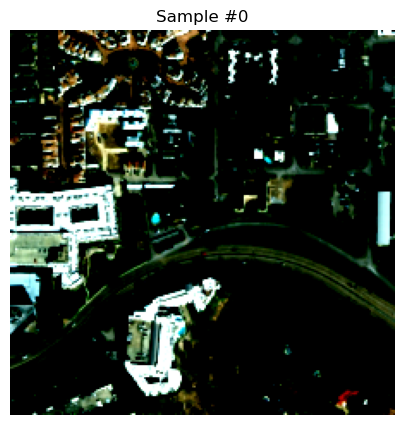

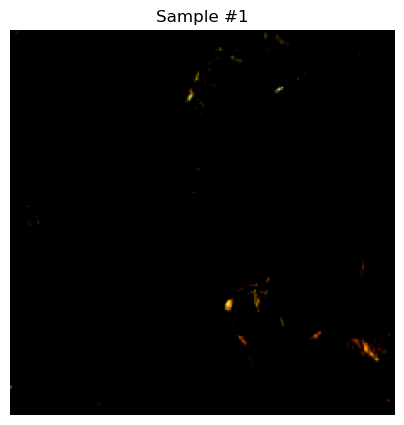

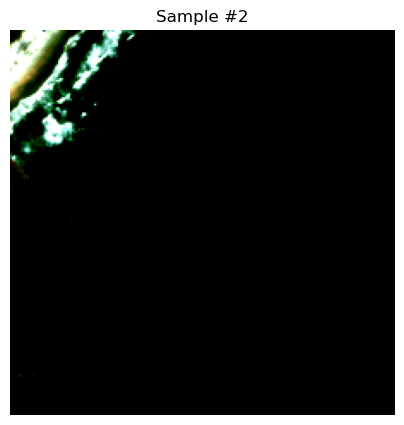

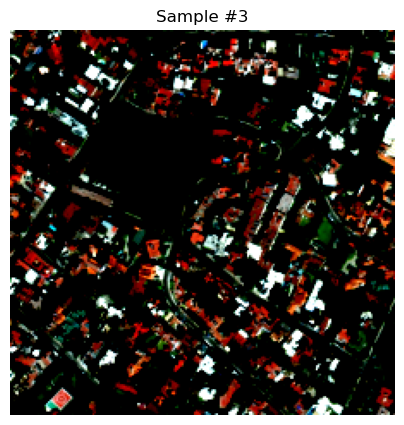

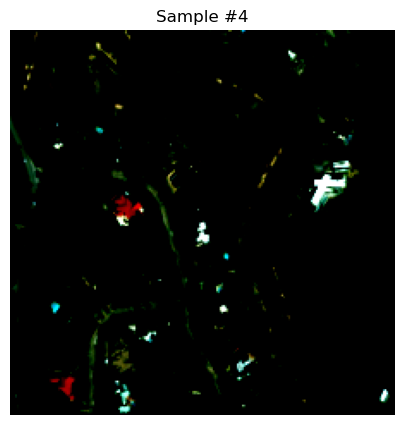

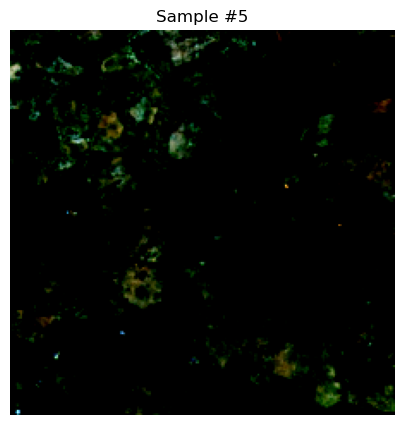

In [20]:
import matplotlib.pyplot as plt
import json

damage_dataset = DisasterDataset(train_image_dir, train_label_dir, transform)

fig = plt.figure()

for i, (image, label) in enumerate(damage_dataset):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    print(i, label)  # Display the index and label
    image = image.permute(1, 2, 0).cpu().numpy()
    plt.imshow(image)  # Display the image
    plt.title('Sample #{}'.format(i))
    plt.axis('off')

    if i == 5:
        plt.show()
        break

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import SubsetRandomSampler

def get_train_test_loaders(dataset, test_split_ratio=0.2, batch_size=4, shuffle_dataset=True, random_seed=0, num_workers=1):

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(test_split_ratio * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, test_indices = indices[split:], indices[:split]

    # Creating data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               sampler=train_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               sampler=test_sampler, num_workers=num_workers)
    return train_loader, test_loader

In [43]:
damage_train_loader, damage_test_loader = get_train_test_loaders(damage_dataset, batch_size=4, random_seed=42, num_workers=4) #batch size should be powers of 2

In [45]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

NameError: name 'net' is not defined

In [46]:
def train_model(net, damage_train_loader, damage_test_loader, optimizer, scheduler, logs_path, model_name, 
                starting_epoch=0, additional_epochs=2, print_every_num_batches=100):
    model_name_base = f'resnet50-{model_name}'+'.ep{}.pth'
    writer = SummaryWriter(logs_path)
    checkpoints_path = logs_path/'checkpoints'
    checkpoints_path.mkdir(parents=True, exist_ok=True)
    if starting_epoch > 0:
        starting_epoch_string = str(starting_epoch).zfill(3)
        model_load_path = checkpoints_path/model_name_base.format(starting_epoch_string)
        net.load_state_dict(torch.load(model_load_path))
    for epoch in range(starting_epoch, starting_epoch+additional_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_epoch_loss = 0.0
        for i, data in enumerate(damage_train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['image'].to(device)
            labels = data['label'].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            running_epoch_loss += loss.item()
            if (i+1) % print_every_num_batches == 0:    # print every 10 mini-batches
                print(f'[epoch {epoch+1}, batch {i +1} ] average loss: {running_loss/print_every_num_batches}')
                running_loss = 0.0

        average_epoch_loss = running_epoch_loss/(i+1)
        writer.add_scalar('Loss/epoch_avg/train', average_epoch_loss, epoch)
        print(f'[epoch {epoch+1}] average training epoch loss: {average_epoch_loss}')
        writer.add_scalar('LR/rate', scheduler.get_last_lr()[0], epoch)
        scheduler.step()
        running_epoch_loss = 0.0
        print("Getting epoch test loss...")
        for i, data in enumerate(test_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['image'].to(device)
            labels = data['label'].to(device)

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_epoch_loss += loss.item()

        average_epoch_loss = running_epoch_loss/(i+1)
        writer.add_scalar('Loss/epoch_avg/test', average_epoch_loss, epoch)
        print(f'[epoch {epoch+1}] average test epoch loss: {average_epoch_loss}')
        epoch_string = str(epoch+1).zfill(3)
        model_save_path = checkpoints_path/model_name_base.format(epoch_string)
        torch.save(net.state_dict(), model_save_path)

    print('Finished Training')
    writer.close()

In [27]:
outputs = pathlib.Path('outputs2')
outputs.mkdir(exist_ok=True, parents=True)

model_name = 'damage_model'

# train damage model
train_model(net, damage_train_loader, damage_test_loader, optimizer, scheduler, outputs, model_name, 
                starting_epoch=0, additional_epochs=1, print_every_num_batches=100)

NameError: name 'pathlib' is not defined

In [31]:
# Download the test data
!wget -O ships.tar.gz https://files.bwsi-remote-sensing.net/data/ships.tar.gz

--2024-08-01 18:52:12--  https://files.bwsi-remote-sensing.net/data/ships.tar.gz
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 52.42.195.52, 52.11.101.209, 52.12.168.120, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|52.42.195.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3749682201 (3.5G) [application/x-gzip]
Saving to: ‘ships.tar.gz’

ships.tar.gz        100%[===================>]   3.49G   127MB/s    in 26s     

2024-08-01 18:52:38 (136 MB/s) - ‘ships.tar.gz’ saved [3749682201/3749682201]



In [32]:
import tarfile
import os

# Function to extract a tar file
def extract_tar_file(tar_path, extract_path):
    with tarfile.open(tar_path, 'r:gz') as tar_ref:
        tar_ref.extractall(extract_path)
        print(f"Extraction of {tar_path} completed.")

# Define the paths
#train_tar_path = 'train_images_labels_targets.tar'
#test_tar_path = 'test_images_labels_targets.tar'
ships_tar_path = 'ships.tar.gz'

#train_extract_path = 'train_images_labels_targets'
#test_extract_path = 'test_images_labels_targets'
ships_extract_path = 'ships'

# Extract the tar files
#extract_tar_file(train_tar_path, train_extract_path)
#extract_tar_file(test_tar_path, test_extract_path)
extract_tar_file(ships_tar_path, ships_extract_path)

Extraction of ships.tar.gz completed.


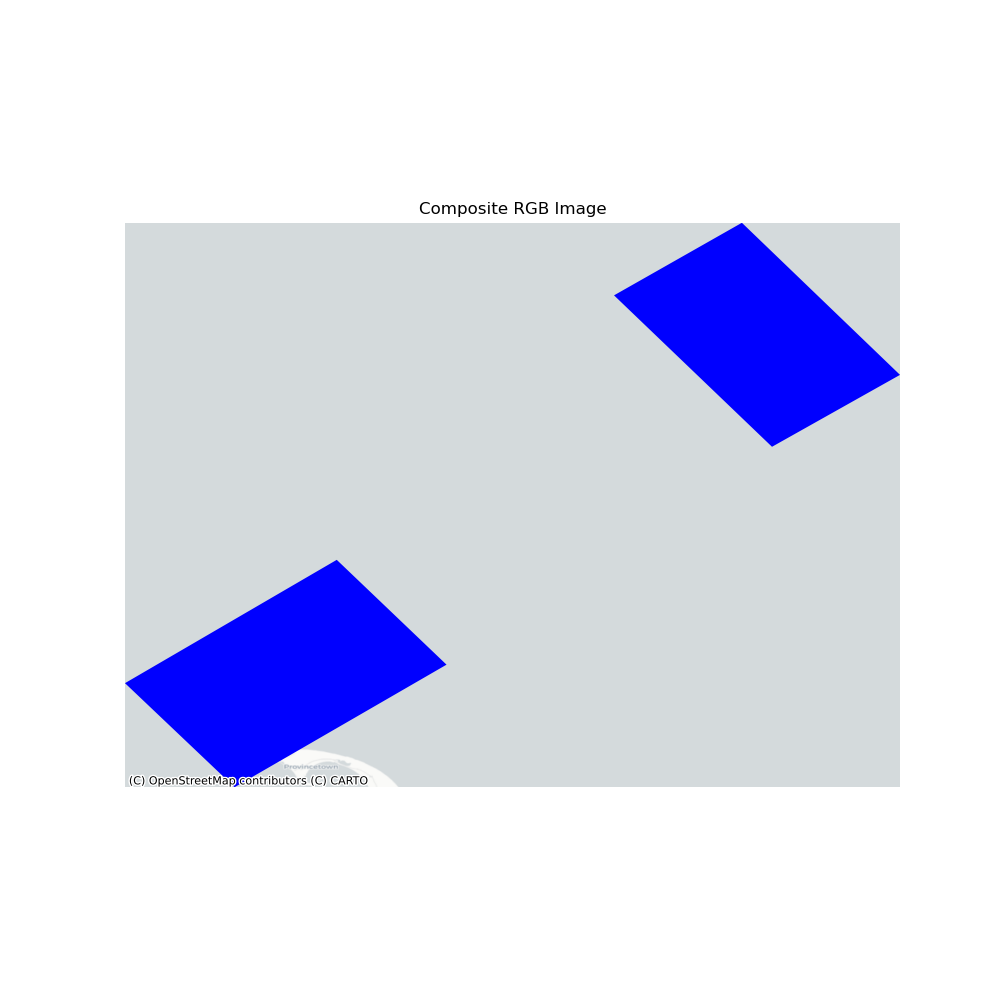

In [199]:
# Function to load a single-band TIFF image
def load_single_band_tif(image_path):
    image = Image.open(image_path)
    image_array = np.array(image)
    return image_array

# Function to normalize an image array
def normalize_image(image_array):
    return (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

# Directory containing the TIFF files
directory = 'ships/scenes/tbqafdnr'

# Load all TIFF files into a dictionary
tiff_files = {}
for filename in os.listdir(directory):
    if filename.lower().endswith('.tif') or filename.lower().endswith('.tiff'):
        image_path = os.path.join(directory, filename)
        tiff_files[filename] = load_single_band_tif(image_path)

# Select any three files to create an RGB image
selected_files = ['VV_dB.tif','VV_dB.tif', 'VV_dB.tif']
#selected_files = ['VV.tif','owiWindDirection.tif', 'owiWindQuality.tif']  # Replace with actual filenames

# Ensure we have exactly 3 selected files
if len(selected_files) != 3:
    raise ValueError("Need exactly 3 TIFF files to create an RGB image")

# Load and normalize the selected bands
bands = []
for filename in selected_files:
    if filename in tiff_files:
        band = tiff_files[filename]
        normalized_band = normalize_image(band)
        bands.append(normalized_band)
    else:
        raise ValueError(f"File {filename} not found in the directory")

# Stack the bands into an RGB image
rgb_image = np.stack(bands, axis=-1)

# Display the composite image
plt.imshow(rgb_image)
plt.title('Composite RGB Image')
plt.axis('off')
plt.show()

In [154]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [200]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [201]:
import rasterio
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Transformer

def get_corners(geotiff_path, target_crs='EPSG:4326'):
    """
    Extract the corner coordinates of a GeoTIFF and transform them to the target CRS.
    
    Parameters:
    - geotiff_path: str, path to the GeoTIFF file
    - target_crs: str, the target coordinate reference system (default is 'EPSG:4326' for WGS84)
    
    Returns:
    - list of tuples containing the coordinates of the corners in the target CRS
    """
    with rasterio.open(geotiff_path) as src:
        # Get the bounding box in the original CRS
        bounds = src.bounds
        original_crs = src.crs
        
        # Define the corners
        corners = [(bounds.left, bounds.top),
                   (bounds.right, bounds.top),
                   (bounds.right, bounds.bottom),
                   (bounds.left, bounds.bottom)]

        # Transform corners to the target CRS
        transformer = Transformer.from_crs(original_crs, target_crs, always_xy=True)
        transformed_corners = [transformer.transform(x, y) for x, y in corners]
        
        return transformed_corners

In [207]:
get_corners('ships/Figure 1 (1).tif', target_crs='EPSG:4326')

[(-70.03853265358978, 42.252375484123014),
 (-70.0345622017004, 42.25466390626296),
 (-70.03148205227342, 42.251714009163685),
 (-70.03545256468746, 42.24942582215224)]

In [264]:
def plot_corners_on_basemap(geotiff_paths, target_crs='EPSG:4326', ax_set={}):
    """
    Plot the corners of a series of GeoTIFFs on a basemap as points.
    
    Parameters:
    - geotiff_paths: list of str, paths to the GeoTIFF files
    - target_crs: str, the target coordinate reference system for plotting (default is 'EPSG:4326')
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Collect all corners in a list
    all_corners = []
    for path in geotiff_paths:
        corners = get_corners(path, target_crs)
        all_corners.extend(corners)
        
        # Create a GeoDataFrame from the corners
        gdf = gpd.GeoDataFrame({'geometry': [Polygon(corners)]}, crs=target_crs)
        gdf.plot(ax=ax, color='blue', markersize=5, label=path)
    
    # Plot the basemap using contextily
    if target_crs == 'EPSG:4326':
        ax.set_xlim(-70.5, -69)
        ax.set_ylim(41,43)
        ax.set(**ax_set)
        ctx.add_basemap(ax, crs=target_crs, source=ctx.providers.CartoDB.Positron)

    plt.title('GeoTIFF Corners on Basemap')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    # plt.legend()
    plt.show()

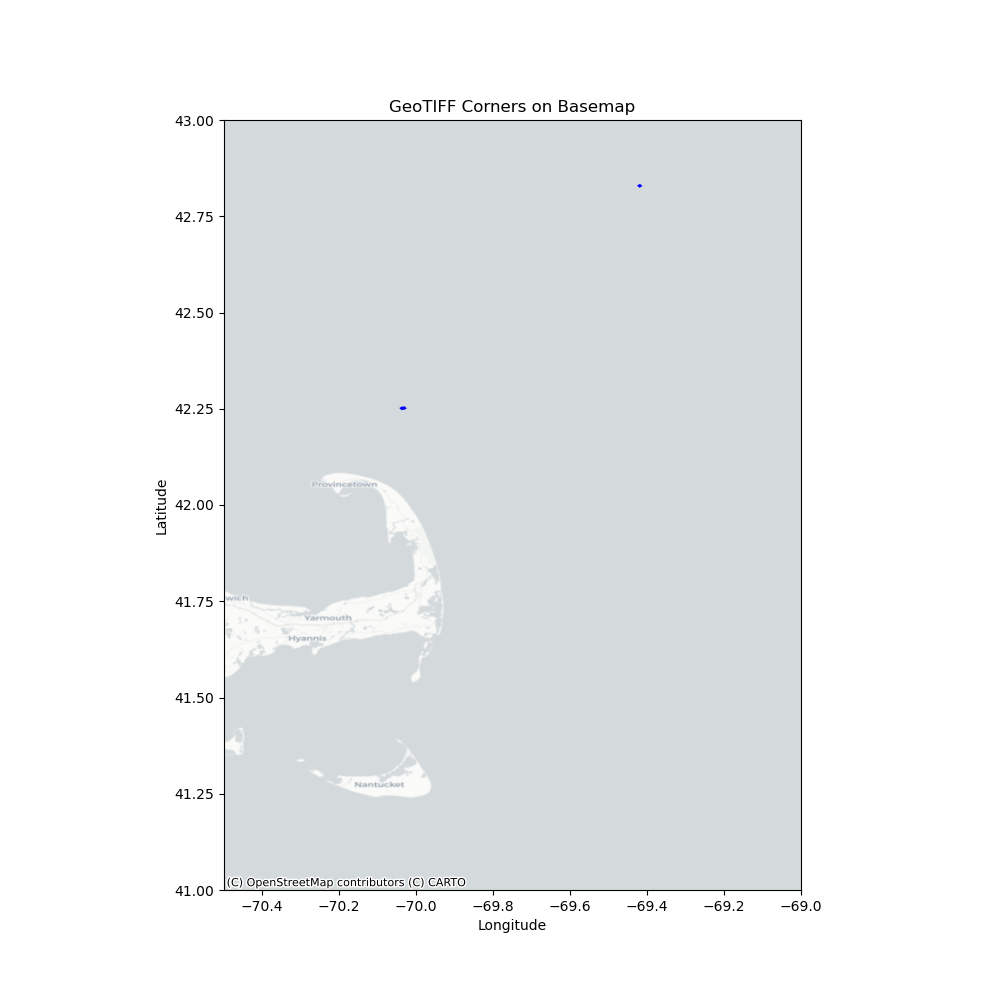

In [265]:
from rasterio.plot import show
#geotiff_paths=  [',]
geotiff_paths=  ['ships/Figure 1 (1).tif',  'ships/Figure_1_(2).tif', 'ships/three.tif' ]
plot_corners_on_basemap(geotiff_paths, target_crs='EPSG:4326', ax_set={})

In [255]:
pip install gdal

Note: you may need to restart the kernel to use updated packages.


In [233]:
#CROPPING

from osgeo import gdal

def crop_geotiff_by_pixels(input_path, output_path, x_offset, y_offset, x_size, y_size):

    """
    Crop a GeoTIFF image to the specified pixel coordinates.

    Parameters:
    - input_path: str, path to the input GeoTIFF file
    - output_path: str, path to save the cropped GeoTIFF file
    - x_offset: int, starting pixel x-coordinate (column)
    - y_offset: int, starting pixel y-coordinate (row)
    - x_size: int, number of pixels in x direction (width)
    - y_size: int, number of pixels in y direction (height)
    """
    # Open the input dataset
    dataset = gdal.Open(input_path)
    if not dataset:
        print(f"Unable to open {input_path}")
        return

    options = gdal.TranslateOptions(
        srcWin=[x_offset, y_offset, x_size, y_size]
    )

    gdal.Translate(output_path, dataset, options=options)
    print(f"Cropped image saved to {output_path}")

input_path = 'ships/scenes/szcsxhjh/VH_dB.tif'
output_path = 'ships/Figure 1 (1).tif'

crop_geotiff_by_pixels(input_path, output_path, 550, 2250, 100, 100)

Cropped image saved to ships/Figure 1 (1).tif


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:32627 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
ERROR 1: PROJ: proj_create_from_name: Open of /opt/conda/share/proj failed


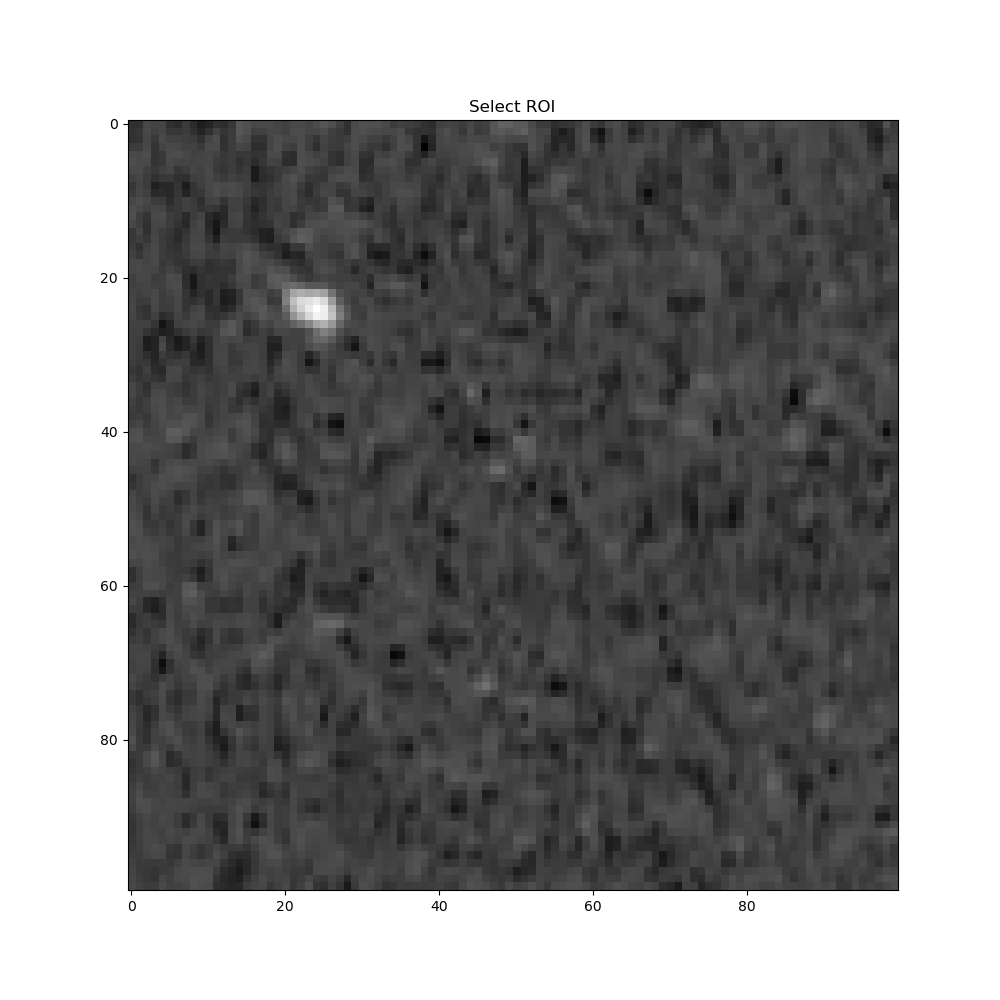

In [243]:
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as ctx

# Function to select ROI on an image
def select_roi(image_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)  # Read the first band

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')
    ax.set_title("Select ROI")

    roi_coords = []

    def onselect(eclick, erelease):
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        print(f"Selected bounding box: ({x1}, {y1}, {x2}, {y2})")
        roi_coords.append((x1, y1, x2, y2))
        plt.close(fig)  # Close the figure after selection

    rect_selector = RectangleSelector(ax, onselect, useblit=True, button=[1], minspanx=5, minspany=5, spancoords='pixels', interactive=True)
    plt.show()

    return roi_coords[0] if roi_coords else None

# Example usage
image_path = 'ships/three.tif'
#image_path = 'ships/Figure 1 (1).tif'
roi = select_roi(image_path)
import IPython
from IPython import get_ipython

# Ensure interactive plotting is enabled
get_ipython().run_line_magic('matplotlib', 'widget')
